# Code to measure Entangling capacity of any Parameterized Quantum Circuit

Sim et.al. in [1] proposed three metrics to represent Ansatz quality of variational circuits namely: Expressibility, Entangling capacity and circuit cost. This notebook implements the Entangling capacity metric that is very useful for any parameterized quantum circuit (or ansatz) for any variational quantum algorithm. While for some domain like physics or chemistry, there are domain-inspired ansatzes, for all other applications the choice of circuits is heuristic-based. With metrics like entangling capacity we can do correlation studies between such metrics and accuracy or precision-recall of an application and accordingly choose an ansatz for the variational algorithm in consideration for that application.

In this notebook we have implemented these metrics and matched our numbers to that of this paper. We have two ways to compute Entangling capacity -using Meyer Wallach measure (as proposed in the paper[1]) and Von-Neumann measure.

In [27]:
from qiskit.quantum_info import partial_trace, Statevector
from parametric_circuits import Ansatz
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi
from qiskit import transpile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


The following cell implements entangling capacity using meyer-wallach measure for a statevector. It expects as input the statevector of $n$ qubits and the total number of qubits $n$ for calculating the the entangling capacity of a particular statevector using Meyer Wallach Measure.
Meyer Wallach measure (this measure is also know as average bipartite entanglement measurement) and is defined by 
$
\begin{equation}
    \mathcal{Q}(|\psi\rangle) = 2 - \frac{2}{n}\sum_{i =1}^{n}Tr(\rho_i^2)
\end{equation}
$
The above equation is the entanglement measurement over just one statevector of the system to get the entangling capability of a parameteric quantum circuit as given in paper[1], we sample over several iteration with different random parameters for the parametric gates and average it to the get the expectation of the entangling capability of the circuit with respect to Meyer - Wallach Measure.
The key properties of using Meyer Wallach measure to calculate entangling capacity metric :

 1. The value $\mathcal{Q}$ is invariant under local unitaries.
 2. It assumes it values between the range $0 \ge \mathcal{Q} \le 1 $.
 3. $\mathcal{Q}(|\psi\rangle) = 0$ if and only if $|\psi\rangle$ is a product state.

 The Meyer-Wallach Measure find its application in quantum information processing due to following advantages:
 1. Due to its nature its a average linear entropy over reduced qubits state i.e. $\mathcal{Q} = \{1 - tr\{\rho^2\}\}$, making it a standard measure over different applications and easy to compare  and comprehend values due to its linear scaling.
 2. The Meyer-Wallach Measure can be applied as a tool for tracking convergence of pseudo-random circuit by comparing the Meyer Wallach Measure with respect to the the Haar Value(The average entanglement of Pseudo Random states $\langle \mathcal{Q}_R \rangle$).
 3. The Meyer-Wallach Measure gives us the global entanglement over the entire statevector. The average over the Parametric Quantum Circuit gives use the measure of the circuit give a quantification of the toal type and number of entangles states a particular circuit can generate.


In [28]:
def compute_ptrace(ket: np.ndarray, num_qubits: int) -> float:
    """Return the values of entanglement capability using meyer-wallach measure.
    Args:
        ket : (numpy.ndarray or list);Vector of amplitudes in 2**N dimensions
        num_qubits : (int)Number of qubits

    Returns:
        q: float; Q value for input ket
    """
    

    entanglement_sum = 0
    for k in range(num_qubits):

        trace_over = [q for q in range(num_qubits) if q != k]
        rho_k = partial_trace(ket, trace_over).data
        entanglement_sum += np.real((np.linalg.matrix_power(rho_k, 2)).trace())

    q = 2 * (1 - (1 / num_qubits) * entanglement_sum)

    return q


The following cell implements entangling capacity using Von-Neumann entropy measure. It expects as input the statevector of $n$ qubits and the total number of qubits $n$ for calculating the the entangling capacity of a particular statevector using Von-Neumann Measure.
Von-Neumann Measure measure (this measure is also know as Von-Neumann Shanon Entropy) and is defined by 
$
\begin{equation}
    \mathcal{Q}(|\psi\rangle) = -\sum_{i=1}^{n}Tr\{\rho_i log_e (\rho_i)\}
\end{equation}
$
The Von-Neumann Measure find its application in quantum information processing due to following advantages:
1. It gives the  local entanglement measure of each qubit by taking the partial trace of reduce density matric given an average over the entanglement capability over the different qubits in a particular statevector.
2. This measure give different measure for different kinds of entanglement for e.g. $|\psi\rangle = \frac{|00\rangle_{1,2}+|11\rangle_{1,2}}{\sqrt{2}}\otimes\frac{|00\rangle_{3,4}+|11\rangle_{3,4}}{\sqrt{2}}$ and the four qubit $GHZ$ state, the four qubit GHZ state give us a higher entanglement measure in the von-neumann measure as compared to Meyer-Wallach measure(which give 1 for both the states.). Hence, it is better able to distinguish between the different kinds of entanglement.


In [29]:
def compute_vn_entropy(ket: np.ndarray, num_qubits: int) -> float:
    """Returns the entangling capabilility using von-neumann entropy.
    Args:
        ket : (numpy.ndarray or list);Vector of amplitudes in 2**N dimensions
        num_qubits : (int)Number of qubits

    Returns:
        q: float; Q value for input ket
    """


    qubit = list(range(num_qubits))  # list of qubits to trace over

    vn_entropy = 0

    for k in range(num_qubits):
        rho_k = qi.partial_trace(ket, qubit[:k] + qubit[k + 1 :]).data
        vn_entropy += qi.entropy(rho_k, base=np.exp(1))
    q = vn_entropy / num_qubits
    return q

The following cells computes entanglement capacity given a parametric circuit, using Meyer Wallach Measure by sampling over different parameter values of the parametric quantum gates to give us an average measure of the Meyer Wallach measure we can expect from a particular parametric quantum circuit.
The function takes as input the total no. of parameters which is also the number of samples , the parametric circuit whose entanglement measure we want to calculate and the backend which we want to use.
Note: We can only use statevector backend to calculate the Entanglement measures.

In [30]:
def meyer_wallach(num_params, feature_dim, layers, circuit_id) -> float:
        """
        Returns:
                net_entanglement_cap: The meyer-wallach entangling capacity of the
                                       given parametric circuit.
        """

        entanglement_cap = []

        for _ in range(num_params):
            
            parametric_circuit = Ansatz(layers + 1, feature_dim, circuit_id).get_ansatz()
            state_vector = Statevector(parametric_circuit)
            state_vector = np.array(state_vector)
            q_value = compute_ptrace(ket=state_vector, num_qubits=feature_dim)
            entanglement_cap.append(q_value)

        entanglement_cap = np.array(entanglement_cap)
        net_entanglement_cap = np.sum(entanglement_cap) / num_params

        return net_entanglement_cap

The following cells computes entanglement capacity given a parametric circuit, using Von-Neumann Measure by sampling over different parameter values of the parametric quantum gates to give us an average measure of the Von-Neumann measure we can expect from a particular parametric quantum circuit.
The function takes as input the total no. of parameters which is also the number of samples , the parametric circuit whose entanglement measure we want to calculate and the backend which we want to use.
Note: We can only use statevector backend to calculate the Entanglement measures.

In [31]:
def von_neumann(num_params,  feature_dim, layers, circuit_id) -> float:

        """
        Returns:
              net_entanglement_cap: The von_neumann entangling capacity of the given parametric circuit.
        """

        entanglement_cap = []

        for _ in range(num_params):

            parametric_circuit = Ansatz(layers + 1, feature_dim, circuit_id).get_ansatz()
            state_vector = Statevector(parametric_circuit).data
            state_vector = np.array(state_vector)
            q_value = compute_vn_entropy(ket=state_vector, num_qubits=feature_dim)
            entanglement_cap.append(q_value)

        entanglement_cap = np.array(entanglement_cap)
        net_entanglement_cap = np.sum(entanglement_cap) / num_params

        return net_entanglement_cap

In order to be able to reproduce the results of the paper [1], we provide an additional code ansatz.py which has the 19 parameterized quantum circuits given in the paper. The following cell calculates the entanglinhg capacity of all the 19 circuits. 
circuit_id can be used if a particular ansatz from the benchmarked ansatz is required. else we can do it for all ansatzes of that code.

feature dim: refers to the number of features in the input data. this is important to know as this determines the number of qubits in the circuit for Z and ZZ feature map. 

repetition: refers to the number of layers of ansatz required. Note: deeper ansatz get more noisy and circuit depth impacts results.

num_eval: refers to the number of runs needed for the circuits. 

In [ ]:
from parametric_circuits import Ansatz
import numpy as np
import pandas as pd


total_circuit = 10
feature_dim = 4
repitition = 5
entanglement_cap = np.zeros((total_circuit, repitition))


for i in range(total_circuit):
    circuit_id = i + 1

    for layers in range(repitition):

        
        ent_cap = meyer_wallach(num_params = 100, feature_dim = feature_dim, layers = layers, circuit_id = circuit_id)
        entanglement_cap[i, layers] = ent_cap

index = ["Ansatz "+str(i+1) for i in range(total_circuit)]
df = pd.DataFrame({'Layer1':entanglement_cap[:,0], "Layer2":entanglement_cap[:,1], "Layer3":entanglement_cap[:,2],
                   "Layer4":entanglement_cap[:,3],"Layer5":entanglement_cap[:,4]}, index = index)
file_name = "entropy_run_5_Layers" 
df.to_csv(file_name + ".csv")

In [25]:
df = pd.read_csv('entropy_run_5_Layers.csv')
df

,Unnamed: 0,Layer1,Layer2,Layer3,Layer4,Layer5
0,Ansatz 1,1.132427e-16,-4.218847e-17,-4.329870e-16,-6.172840e-16,-5.995204e-17
1,Ansatz 2,5.401581e-01,5.556001e-01,6.900341e-01,6.438951e-01,6.726030e-01
2,Ansatz 3,4.720906e-02,1.204134e-01,1.817087e-01,2.231124e-01,2.382670e-01
3,Ansatz 4,8.341888e-02,1.888078e-01,3.073650e-01,3.397621e-01,3.802105e-01
4,Ansatz 5,2.223875e-01,3.931126e-01,4.454848e-01,4.625990e-01,4.391473e-01
5,Ansatz 6,2.530011e-01,4.370052e-01,4.661679e-01,5.276274e-01,5.585503e-01
6,Ansatz 7,7.516283e-02,1.609968e-01,2.594939e-01,3.152684e-01,3.666315e-01
7,Ansatz 8,8.999807e-02,2.076772e-01,2.773615e-01,3.431136e-01,4.149008e-01
8,Ansatz 9,1.000000e+00,1.000000e+00,1.000000e+00,5.924633e-01,6.888367e-01
9,Ansatz 10,3.865358e-01,6.801451e-01,8.198149e-01,7.264927e-01,7.441896e-01


to Plot Entangling Capacity of all 10 circuits across 5 layers. Observe how entangling capacity increases with increasing the mumber of layers which is intuitive as the number of entangling gates also increase

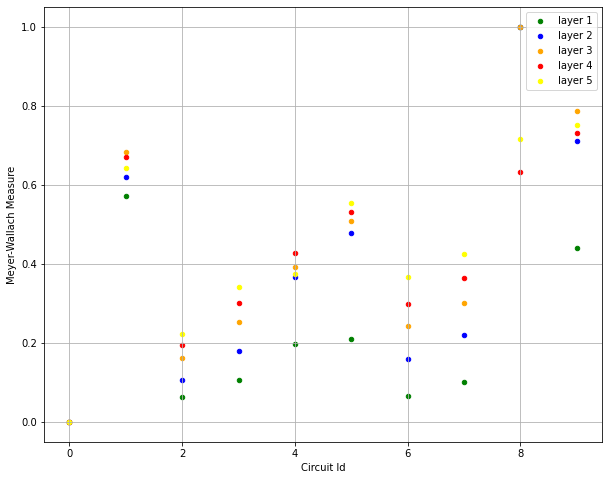

In [9]:
# import seaborn as sns
ax = plt.gca()
color = ['green', 'blue', 'orange', 'red', 'yellow']
for i in range(5):
    df.reset_index().plot.scatter(x = 'index', y = 'Layer'+str(i+1), color = color[i],marker = 'o', label = 'layer '+str(i+1), figsize = (10,8), grid = True, ax = ax)

ax.set_xlabel('Circuit Id')
ax.set_ylabel('Meyer-Wallach Measure')
plt.show()

